<a href="https://colab.research.google.com/github/antoniovfonseca/summarize-change-components/blob/main/QuantityExchangeShift24_NASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

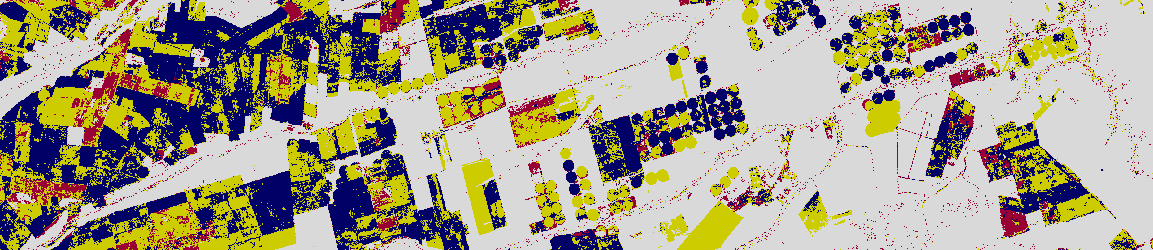

# **Detecting Change in a Cross-Tab Matrix**

---


**Authors:** Antonio Fonseca, Robert Gilmore Pontius Jr

**Institution:** Clark University

**Purpose:** This notebook summarizes the overall change and the class-level changes during time intervals by computing four componentes: Quantity, Exchange, Shift and Alternation components.

**Data Description:**
- **Source:** [MapBiomas Project](https://brasil.mapbiomas.org/en/)
- **Coverage:** Western Bahia, Brazil, 5-years time intervals from 1990 to 2020.
- **Resolution and Format:** TIF files at 30m resolution.

**Notebook Outline:**
1. **Data Preparation:** Setup and initial configuration.
2. **Visualization:** Techniques to visualize the input raster data.
3. **Change Detection:** Analysis using custom methods to detect and quantify changes over time.
4. **Results Export:** Saving results and generating plots for presentation and further analysis.

[PontiPy Library](https://github.com/verma-priyanka/pontiPy)

**Acknowledgements:**

The United States National Aeronautical and Space Administration supported this work through the Land-Cover and Land-Use Change Mission Directorate via the grant 80NSSC23K0508 entitled ["Irrigation as climate-change adaptation in the Cerrado biome of Brazil evaluated with new quantitative methods, socio-economic analysis, and scenario models."](https://lcluc.umd.edu/projects/irrigation-climate-change-adaptation-cerrado-biome-brazil-evaluated-new-quantitative)




## **1.Data Preparation**


---



### **1.1.Install Python Libraries**


In [ ]:
# Installing Python Libraries for Raster Data Handling and Plotting
!pip install rasterio -q
!pip install seaborn -q
!pip install xlsxwriter -q
!pip install matplotlib-scalebar -q
!pip install matplotlib-map-utils -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 98.0 MB/s eta 0:00:00


### **1.2.Importing Libraries**

In [ ]:
# Importing Libraries
import os
import sys
import glob
import time
import pickle
import numba
import numba as nb
import numpy as np
import pandas as pd
import xlsxwriter
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.enums import Resampling

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_map_utils import scale_bar, north_arrow
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize, LinearSegmentedColormap
from matplotlib.patches import Patch, Rectangle, FancyArrowPatch

from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [ ]:
total_start_time = time.time()

### **1.3.Mounting Google Drive**



In [ ]:
# Mounting Google Drive in Colab for File Access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **1.4.Setting Paths to Image Files**

The user must include the year in the raster map name.

In [ ]:
# List of input image paths
image_paths = [
    '/content/drive/MyDrive/IALE-APP/input/lulc_mapbiomas_1990.rst',
    '/content/drive/MyDrive/IALE-APP/input/lulc_mapbiomas_1995.rst',
    '/content/drive/MyDrive/IALE-APP/input/lulc_mapbiomas_2000.rst',
    '/content/drive/MyDrive/IALE-APP/input/lulc_mapbiomas_2005.rst',
    '/content/drive/MyDrive/IALE-APP/input/lulc_mapbiomas_2010.rst',
    '/content/drive/MyDrive/IALE-APP/input/lulc_mapbiomas_2015.rst',
    '/content/drive/MyDrive/IALE-APP/input/lulc_mapbiomas_2020.rst'
]
mask_path = '/content/drive/MyDrive/IALE-APP/input/WesternBahiaMask.tif'

### **1.5.Setting Years of the Time Intervals**

In [ ]:
# Defining Year Labels for Time-Series Analysis
years = [1990,1995,2000,2005,2010,2015,2020]

### **1.6.Setting the classes**

In [ ]:
# Defining the ID and Name of the Classes
class_labels_dict = {
     0: {"name": "Backgroud",                  "rename": "Background", "color": "#ffffff", "color1": "#ffffff", "color2": "#ffffff", "color3": "#ffffff"},
     4: {"name": "Savanna Formation",          "rename": "Savanna",    "color": "#7dc975", "color1": "#ff0000", "color2": "#ff0000", "color3": "#8b0000"},
    12: {"name": "Grassland",                  "rename": "Grassland",  "color": "#d6bc74", "color1": "#8b0000", "color2": "#8b0000", "color3": "#b22222"},
     3: {"name": "Forest Formation",           "rename": "Forest",     "color": "#1f8d49", "color1": "#1f8d49", "color2": "#ffffcc", "color3": "#cd5c5c"},
    33: {"name": "River, Lake and Ocean",      "rename": "Water",      "color": "#2532e4", "color1": "#ffff00", "color2": "#ffff99", "color3": "#ffff00"},
    46: {"name": "Coffee",                     "rename": "Coffee",     "color": "#d68fe2", "color1": "#ffd700", "color2": "#ffff66", "color3": "#ffd700"},
    29: {"name": "Rocky Outcrop",              "rename": "Rocky",      "color": "#ffaa5f", "color1": "#eee8aa", "color2": "#ffff00", "color3": "#eee8aa"},
    11: {"name": "Wetland",                    "rename": "Wetland",    "color": "#519799", "color1": "#f0e68c", "color2": "#cc9900", "color3": "#f0e68c"},
    24: {"name": "Urban Area",                 "rename": "Urban",      "color": "#d4271e", "color1": "#daa520", "color2": "#ffcccc", "color3": "#daa520"},
     9: {"name": "Forest Plantation",          "rename": "Plantation", "color": "#7a5900", "color1": "#b8860b", "color2": "#ffcc99", "color3": "#b8860b"},
    48: {"name": "Other Perennial Crops",      "rename": "Perennial",  "color": "#e6ccff", "color1": "#fafad2", "color2": "#ffcc66", "color3": "#ffec8b"},
    25: {"name": "Other non Vegetated Areas",  "rename": "Barren",     "color": "#db4d4f", "color1": "#db4d4f", "color2": "#ffcc00", "color3": "#ffff99"},
    21: {"name": "Mosaic of Uses",             "rename": "Mosaic",     "color": "#ffefc3", "color1": "#0000ff", "color2": "#ff9900", "color3": "#ffdb58"},
    62: {"name": "Cotton (beta)",              "rename": "Cotton",     "color": "#ff69b4", "color1": "#ff69b4", "color2": "#ff66ff", "color3": "#87ceeb"},
    15: {"name": "Pasture",                    "rename": "Pasture",    "color": "#edde8e", "color1": "#edde8e", "color2": "#cc00cc", "color3": "#1e90ff"},
    41: {"name": "Other Temporary Crops",      "rename": "Temporary",  "color": "#f54ca9", "color1": "#1e90ff", "color2": "#0000ff", "color3": "#0000ff"},
    39: {"name": "Soybean",                    "rename": "Soybean",    "color": "#f5b3c8", "color1": "#00bfff", "color2": "#00bfff", "color3": "#000080"},
}
class_labels = [class_labels_dict[key]["rename"] for key in sorted(class_labels_dict.keys())]

### **1.2.7.Setting Paths to Output Files**

In [ ]:
# Setting Output Directory Path for Data Storage on Google Drive
output_path = "/content/drive/MyDrive/IALE-APP/output22_nasa/"

# Check if the folder exists, if not, create the folder
if not os.path.exists(output_path):
    os.makedirs(output_path)
    print("Folder created:", output_path)
else:
    print("Folder already exists.")

Folder already exists.


## **2.Load the Maps**


---



### **2.1 Apply Mask**

In [ ]:
def apply_mask_to_images(image_paths, output_path, mask_path=None):
    """
    Apply a given mask to a series of image files and save the masked images as 8-bit TIFFs.

    Parameters:
    image_paths (list): List of paths to the images to which the mask will be applied.
    output_path (str): Directory to save the masked images.
    mask_path (str, optional): Path to the mask file. If None, no mask is applied.

    Returns:
    list: A list containing the paths to the saved masked images.
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    saved_paths = []

    # Load mask if provided
    mask_data = None
    if mask_path:
        with rasterio.open(mask_path) as mask_file:
            mask_data = mask_file.read(1)

    # Apply the mask to each image specified in the image_paths
    for path in image_paths:
        with rasterio.open(path) as image:
            meta = image.meta.copy()

            # Ensure the data type is uint8 and set the correct driver for TIFF files
            meta['dtype'] = 'uint8'
            meta['nodata'] = 0
            meta['driver'] = 'GTiff'
            meta['compress'] = 'lzw'

            # Read all bands of the image and apply mask if provided
            image_data = image.read(1)
            if mask_data is not None:
                masked_data = (image_data * (mask_data == 1)).astype('uint8')
            else:
                masked_data = image_data.astype('uint8')

            # Construct the path for the masked image
            base_name = os.path.basename(path).replace('.rst', '_masked.tif')
            masked_path = os.path.join(output_path, base_name)

            # Save the masked image
            with rasterio.open(masked_path, 'w', **meta) as dest:
                dest.write(masked_data, 1)

            saved_paths.append(masked_path)

    return saved_paths

# Assuming image_paths, mask_path, and output_path are already defined
masked_image_paths = apply_mask_to_images(image_paths, output_path, mask_path)

# Print the paths of the saved masked images
for path in masked_image_paths:
    print(path)

/content/drive/MyDrive/IALE-APP/output22_nasa/lulc_mapbiomas_1990_masked.tif
/content/drive/MyDrive/IALE-APP/output22_nasa/lulc_mapbiomas_1995_masked.tif
/content/drive/MyDrive/IALE-APP/output22_nasa/lulc_mapbiomas_2000_masked.tif
/content/drive/MyDrive/IALE-APP/output22_nasa/lulc_mapbiomas_2005_masked.tif
/content/drive/MyDrive/IALE-APP/output22_nasa/lulc_mapbiomas_2010_masked.tif
/content/drive/MyDrive/IALE-APP/output22_nasa/lulc_mapbiomas_2015_masked.tif
/content/drive/MyDrive/IALE-APP/output22_nasa/lulc_mapbiomas_2020_masked.tif


### **2.2 Display the Maps**

The code defines a function to find files with a given suffix and returns their paths. It then defines a function that plots each raster file with a specified color map, black-bordered grid cells, and a legend. It reads the raster data with rasterio, reshapes it, applies the color map, and arranges the images in a single row of subplots. It sets each plot’s title with the provided year, hides the axes, draws black rectangles around each cell, and includes a custom legend. Finally, it saves the plot as a JPEG and displays it. After defining the directory and suffix, the code gathers all matching raster files and plots them using these functions.

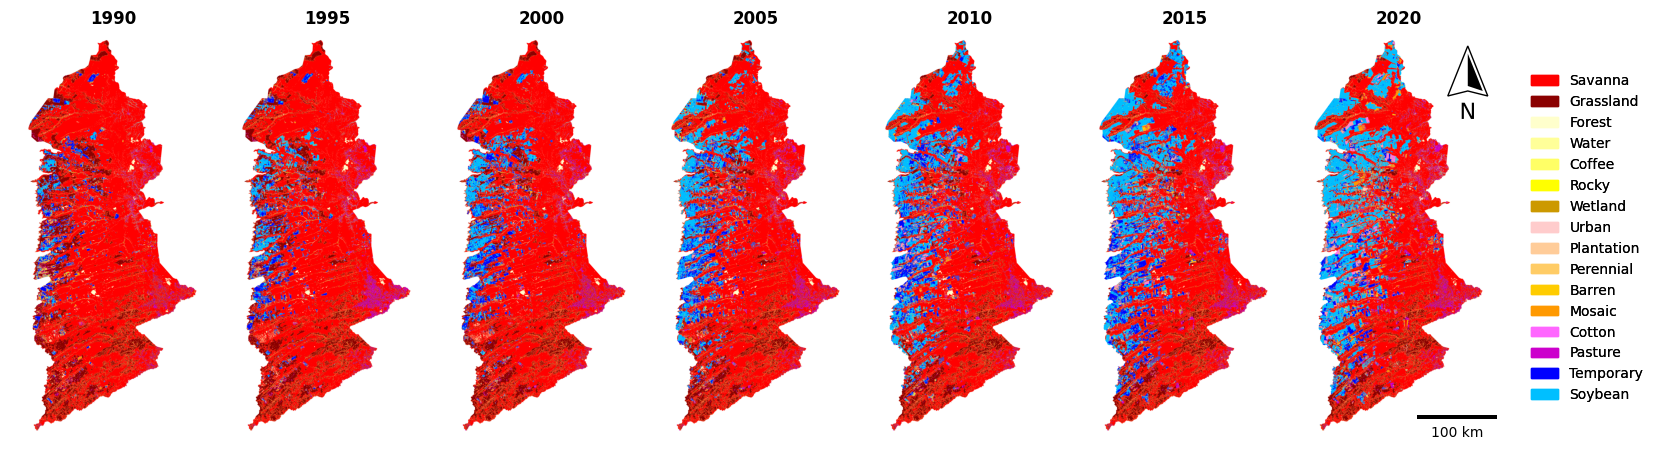

In [ ]:
def plot_classified_images(image_paths, class_map, years, output_path):
    """
    Plots saved classified images with legends and specified colors,
    inverting the legend order.

    Parameters:
    image_paths (list): Paths to the images to be plotted.
    class_map (dict): Dictionary containing class IDs with names and colors.
    years (list): List of years corresponding to each image.
    output_path (str): Directory where images are stored.
    """

    # Generate paths from years and suffix
    image_paths = [
        os.path.join(output_path, f)
        for year in years
        for f in os.listdir(output_path)
        if f.endswith(f"{year}_masked.tif")
    ]
    plt.close()
    n_images = len(image_paths)
    fig, axs = plt.subplots(1, n_images,
                            figsize=(15, 5),
                            sharey=True,
                            constrained_layout=True)

    # Prepare the colormap
    sorted_keys = sorted(class_map.keys())
    colors = [class_map[key]["color2"] for key in sorted_keys]
    cmap = ListedColormap(colors)
    class_labels = [class_map[key]["rename"] for key in sorted_keys]
    class_values = sorted_keys

    # BoundaryNorm needs monotonically increasing boundaries
    norm = BoundaryNorm(class_values + [class_values[-1] + 1], cmap.N)

    # Plot each image
    for i, path in enumerate(image_paths):
        ax = axs[i] if n_images > 1 else axs
        with rasterio.open(path) as src:
            data = src.read(1, out_shape=(src.height // 4, src.width // 4),
                            resampling=Resampling.bilinear)

        ax.imshow(data,
                  cmap=cmap,
                  norm=norm)
        ax.set_title(f"{years[i]}",
                     fontweight='bold')
        ax.axis('off')

    # Custom legend elements
    legend_elements = [
    plt.Rectangle((0, 0), 1, 1,
                  color=class_labels_dict[key]["color2"],
                  label=class_labels_dict[key]["rename"])
    for key in class_labels_dict if key != 0
    ]

    fig.legend(handles=legend_elements,
       loc='center right',
       bbox_to_anchor=(1.1, 0.5),
       frameon=False)

    # Get handles and labels from legend elements
    handles = [elem for elem in legend_elements]
    labels = [elem.get_label() for elem in legend_elements]

    fig.legend(
      handles=handles,
      labels=labels,
      loc='center right',
      bbox_to_anchor=(1.1, 0.5),
      frameon=False)

    # Add scale bar
    scalebar = ScaleBar(
        1/10000,
        units='km',
        length_fraction=0.4,
        location='lower right',
        scale_loc='bottom',
        color='black',
        box_alpha=0,
        scale_formatter=lambda value, _: f"{int(value)} km"
    )
    ax.add_artist(scalebar)

    # Add north arrow
    north_arrow(
        ax,
        location="upper right",
        shadow=False,
        rotation={"degrees":0}
    )

    plt.savefig(os.path.join(output_path,
                             "plot_input_maps2.jpeg"),
                format='jpeg',
                bbox_inches="tight",
                dpi=300)

    plt.show()

# Call the function to plot the images
plot_classified_images(masked_image_paths,
                       class_labels_dict,
                       years,
                       output_path)

## **3.Generate the Confusion Matrix**


---



In this section, the computer code will generate three confusion matrix. The first one is relate to each time interval. The second one is the confusion matrix for the temporal extent, which is represented for the first and last time point of the time extent. The last one is a confusion matrix that represents the sum of all time intervals.

Before generate the confusion matrix, the computer code will analyze the presence of 0, NULL and NA value in all maps. If there is a presence of one of these values, the computer code will create a mask with these values and will remove all the pixels in the same position in all maps and years.

All the confusion matrix will be salved in the Google Drive in the ".csv" format.



In [ ]:
# Generate the Confusion Matrix
def generate_mask_and_flatten_rasters(output_path, suffix='_masked.tif'):
    """
    Reads rasters with a specific suffix from a directory, applies a mask where
    data is zero, missing, or NaN, and flattens the non-masked values.

    Parameters:
    output_path (str): Directory containing raster files to process.
    suffix (str): File suffix to identify relevant rasters.

    Returns:
    list of numpy arrays: Flattened arrays of non-masked raster data for further analysis.
    """
    image_paths = [os.path.join(output_path, f)
                   for f in os.listdir(output_path) if f.endswith(suffix)]
    image_paths.sort()

    all_data = []
    all_masks = []

    # Read and mask all rasters
    for path in image_paths:
        with rasterio.open(path) as src:
            data = src.read(1)
            mask = (data == 0) | (data == src.nodata) | np.isnan(data)
            all_masks.append(mask)
            all_data.append(data)

    # Create combined mask
    combined_mask = np.any(all_masks, axis=0)

    # Return flattened data
    return [data[~combined_mask].flatten() if np.any(combined_mask)
            else data.flatten() for data in all_data]

def generate_all_matrices(output_path, suffix='_masked.tif'):
    """Generate all required matrices and save to CSV"""
    global years

    # Get processed data
    flattened_data = generate_mask_and_flatten_rasters(output_path, suffix)

    # Validate year count
    if len(years) != len(flattened_data):
        raise ValueError(f"Mismatch: {len(years)} years vs {len(flattened_data)} rasters")

    # Get class labels from data
    all_classes = np.unique(np.concatenate(flattened_data)).astype(int)

    # Generate interval matrices
    for i in range(len(flattened_data)-1):
        cm = confusion_matrix(flattened_data[i],
                              flattened_data[i+1],
                              labels=all_classes)
        pd.DataFrame(cm,
                     index=all_classes,
                     columns=all_classes
        ).to_csv(os.path.join(output_path,
                              f'confusion_matrix_{years[i]}-{years[i+1]}.csv'))

    # Generate extent matrix
    extent_matrix = confusion_matrix(flattened_data[0],
                                     flattened_data[-1],
                                     labels=all_classes)
    pd.DataFrame(extent_matrix,
                 index=all_classes,
                 columns=all_classes
    ).to_csv(os.path.join(output_path,
                          f'confusion_matrix_extent_{years[0]}-{years[-1]}.csv'))

    # Generate sum matrix
    sum_matrix = np.zeros((len(all_classes), len(all_classes)), dtype=int)
    for i in range(len(flattened_data)-1):
        sum_matrix += confusion_matrix(flattened_data[i],
                                       flattened_data[i+1],
                                       labels=all_classes)
    pd.DataFrame(sum_matrix,
                 index=all_classes,
                 columns=all_classes
    ).to_csv(os.path.join(output_path,
                          f'confusion_matrix_sum_{years[0]}-{years[-1]}.csv'))

    # Generate alternation matrix
    alternation_matrix = sum_matrix - extent_matrix
    pd.DataFrame(alternation_matrix,
                 index=all_classes,
                 columns=all_classes
    ).to_csv(os.path.join(output_path,
                          f'confusion_matrix_alternation_{years[0]}-{years[-1]}.csv'))

    return years, all_classes

def main(output_path):
    """Matrix generation workflow"""
    # Create output directory if needed
    os.makedirs(output_path, exist_ok=True)

    # Generate all matrices
    print("Generating confusion matrices...")
    years, all_classes = generate_all_matrices(output_path)

    print(f"Detected classes: {all_classes}")
    print("Matrices saved in:", output_path)

if __name__ == "__main__":
    main(output_path)

Generating confusion matrices...
Detected classes: [ 3  4  9 11 12 15 21 24 25 29 33 39 41 46 48 62]
Matrices saved in: /content/drive/MyDrive/IALE-APP/output22_nasa/


## **4.Components of Change**


---

The code calculates components of change from confusion matrices generetaed in the previous step. It features a ComponentCalculator class that processes matrices to determine the gain and loss of quantity, the exchanges, and shifts. The process_matrix function handles matrices for defined time intervals and the main function systematically processes these matrices for each time slice, aggregates the results, and exports the outcomes to a CSV file.

In [ ]:
class ComponentCalculator:
    def __init__(self, confusion_matrix):
      """
      Initialize with a confusion matrix, convert data types, and set up
      structure for class components
      """
      self.matrix = confusion_matrix.astype(int)
      self.num_classes = confusion_matrix.shape[0]
      self.class_components = []
      self.total_components = {
          'Quantity_Gain': 0, 'Quantity_Loss': 0,
          'Exchange_Gain': 0, 'Exchange_Loss': 0,
          'Shift_Gain': 0, 'Shift_Loss': 0
        }

    def calculate_components(self):
      """
      Calculate change components for each class based on the confusion matrix
      """
      for class_idx in range(self.num_classes):
          gain_sum = np.sum(self.matrix[:, class_idx])
          loss_sum = np.sum(self.matrix[class_idx, :])
          q_gain = max(0, gain_sum - loss_sum)
          q_loss = max(0, loss_sum - gain_sum)
          mutual = np.sum(np.minimum(
              self.matrix[class_idx, :],
              self.matrix[:, class_idx]
          ))
          exchange = mutual - self.matrix[class_idx, class_idx]
          total_trans = loss_sum - self.matrix[class_idx, class_idx]
          shift = max(0, total_trans - q_loss - exchange)
          self.class_components.append({
              'Quantity_Gain': q_gain,
              'Quantity_Loss': q_loss,
              'Exchange_Gain': exchange,
              'Exchange_Loss': exchange,
              'Shift_Gain': shift,
              'Shift_Loss': shift
          })
      return self

def process_matrix(matrix_type):
    """
    Process different types of matrices, calculate components, and compile
    results.
    """
    results = []

    try:
        # Determine file name based on matrix type and load data
        if matrix_type == 'extent':
            fname = f'confusion_matrix_extent_{years[0]}-{years[-1]}.csv'
        elif matrix_type == 'sum':
            fname = f'confusion_matrix_sum_{years[0]}-{years[-1]}.csv'
        else:
            fname = f'confusion_matrix_{matrix_type}.csv'

        df = pd.read_csv(os.path.join(output_path, fname), index_col=0)

        # Get the actual class labels from the DataFrame index
        matrix_classes = df.index.tolist()

        calc = ComponentCalculator(df.values).calculate_components()

        for idx, cls in enumerate(matrix_classes):
            comp = calc.class_components[idx]
            for component in ['Quantity', 'Exchange', 'Shift']:
                if matrix_type in ['extent', 'sum'] and component in ['Exchange', 'Shift']:
                    component_name = f"Allocation_{component}"
                else:
                    component_name = component
                results.append({
                    'Time_Interval': matrix_type,
                    'Class': cls,
                    'Component': component_name,
                    'Gain': comp[f'{component}_Gain'],
                    'Loss': comp[f'{component}_Loss']
                })

    except FileNotFoundError:
        print(f"Missing {matrix_type} matrix")

    return results

def main(output_path):
    """
    Optimized main function to process all matrices with:
    - Reduced code duplication
    - Consolidated matrix type handling
    - Simplified alternation processing
    """
    all_results = []
    matrix_types = []

    # Process yearly intervals
    matrix_types.extend([f"{years[t]}-{years[t+1]}" for t in range(len(years)-1)])

    # Process static matrix types
    matrix_types.extend(['extent', 'sum'])

    # Single processing loop for all standard matrices
    for mtype in matrix_types:
        all_results.extend(process_matrix(mtype))

    # 3. Handle alternation matrix separately
    alternation_path = os.path.join(output_path,
        f'confusion_matrix_alternation_{years[0]}-{years[-1]}.csv')

    if os.path.exists(alternation_path):
        try:
            df_alt = pd.read_csv(alternation_path, index_col=0)
            calc = ComponentCalculator(np.abs(df_alt.values)).calculate_components()

            for idx, cls in enumerate(df_alt.index.astype(int)):
                comp = calc.class_components[idx]
                all_results.extend([{
                    'Time_Interval': 'alternation',
                    'Class': cls,
                    'Component': 'Alternation_Exchange',
                    'Gain': comp['Exchange_Gain'],
                    'Loss': comp['Exchange_Loss']
                }, {
                    'Time_Interval': 'alternation',
                    'Class': cls,
                    'Component': 'Alternation_Shift',
                    'Gain': comp['Shift_Gain'],
                    'Loss': comp['Shift_Loss']
                }])
        except Exception as e:
            print(f"Error processing alternation matrix: {str(e)}")
    else:
        print("Alternation matrix missing")

    # Export results
    pd.DataFrame(all_results).to_csv(
        os.path.join(output_path, 'change_components.csv'),
        index=False
    )
    print(f"Components CSV saved: {os.path.join(output_path, 'change_components.csv')}")

if __name__ == "__main__":
    main(output_path)

Components CSV saved: /content/drive/MyDrive/IALE-APP/output22_nasa/change_components.csv


## **5.Graphics**

---



### **5.1 Setting the parameters for the graphics**

In [ ]:
# Read the generated CSV file
csv_path = os.path.join(output_path, 'change_components.csv')
df = pd.read_csv(csv_path)

# Common color definitions for components
components_color = {
    'Quantity': '#1f77b4',
    'Exchange': '#ffd700',
    'Shift': '#2ca02c',
    'Allocation_Exchange': '#ffd700',
    'Allocation_Shift': '#2ca02c',
    'Alternation_Exchange': '#ff8080',
    'Alternation_Shift': '#990099'
}

# Desired order for legend and bars
component_order = [
    'Quantity',
    'Allocation_Exchange',
    'Allocation_Shift',
    'Alternation_Exchange',
    'Alternation_Shift'
]

# Common figure setup
figsize = (10, 6)
title_fontsize = 18
label_fontsize = 16
tick_labelsize = 14
legend_fontsize = 14

### **5.2 Change Components by Time Interval**

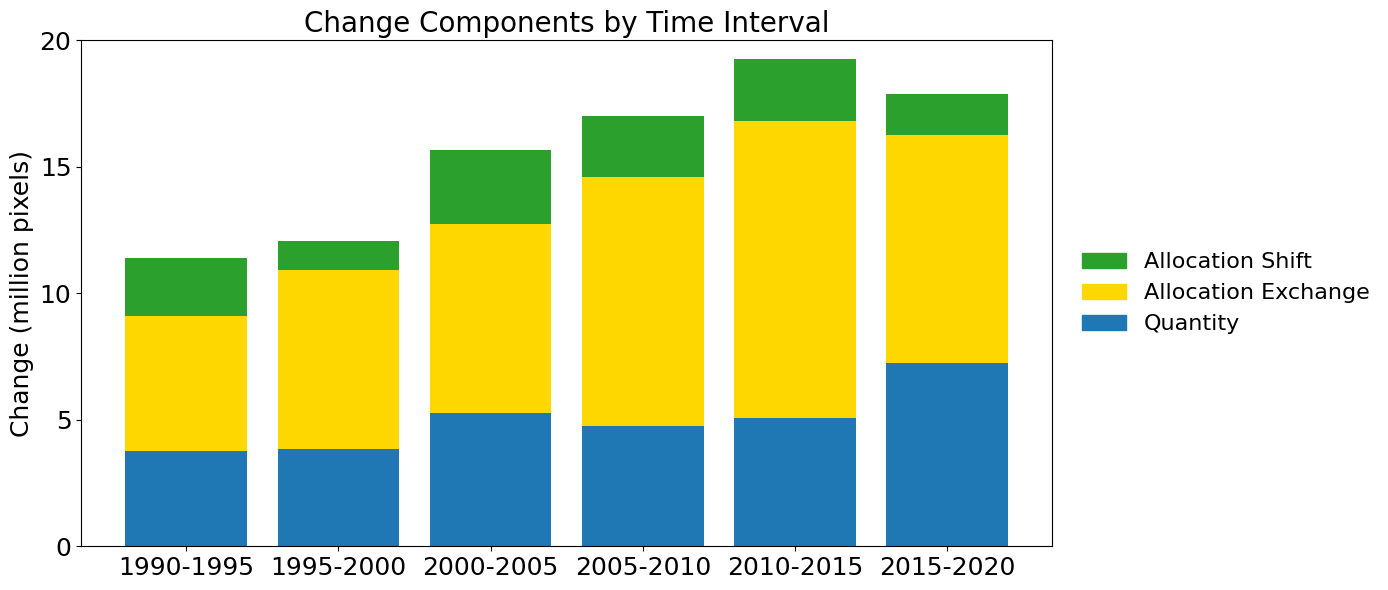

In [ ]:
# Read the generated CSV file
csv_path = os.path.join(output_path, 'change_components.csv')
df = pd.read_csv(csv_path)

# Filter only regular time intervals
time_df = df[df['Time_Interval'].str.contains('-')]

# Prepare data structure
totals = time_df.groupby(['Time_Interval', 'Component'])['Gain'].sum().unstack()

# Create figure and axes
fig, ax = plt.subplots(figsize=(14, 6))

# Colors for the bars
colors = ['#1f77b4', # Quantity
          '#ffd700', # Exchange
          '#2ca02c'] # Shift

COMPONENT_COLORS = {
    'Quantity': '#1f77b4',
    'Exchange': '#ffd700',
    'Shift': '#2ca02c'
}

# Plot bars for totals
for idx, comp in enumerate(['Quantity', 'Exchange', 'Shift']):
    bottom_values = totals[['Quantity', 'Exchange', 'Shift']].iloc[:, :idx].sum(axis=1) if idx > 0 else 0
    ax.bar(totals.index, totals[comp],
           label=comp, color=colors[idx],
           edgecolor='none', bottom=bottom_values)

# formating axes
ax.set_ylabel('Change (million pixels)',
              fontsize=18)
ax.set_title('Change Components by Time Interval',
             fontsize=20)
ax.tick_params(axis='both', which='major',
               labelsize=18)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Configuring y-axis to scale with millions
def millions_formatter(x, pos):
    return '%1.0f' % (x * 1e-6)
ax.set_ylim(0, 2.0e7)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5000000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))


# Legend
legend_elements = [
    plt.Rectangle((0,0),1,1, color=COMPONENT_COLORS['Shift'], label='Allocation Shift'),
    plt.Rectangle((0,0),1,1, color=COMPONENT_COLORS['Exchange'], label='Allocation Exchange'),
    plt.Rectangle((0,0),1,1, color=COMPONENT_COLORS['Quantity'], label='Quantity')
]

ax.legend(handles=legend_elements,
          loc='center left',
          bbox_to_anchor=(1.01, 0.5),
          fontsize=16,
          frameon=False)

# Save and show plot
plt.tight_layout()
plt.savefig(os.path.join(output_path, "graphic_change_components_time_interval.jpeg"),
            format='jpeg',
            dpi=300)
plt.show()

### **5.3 Change Components Overall**

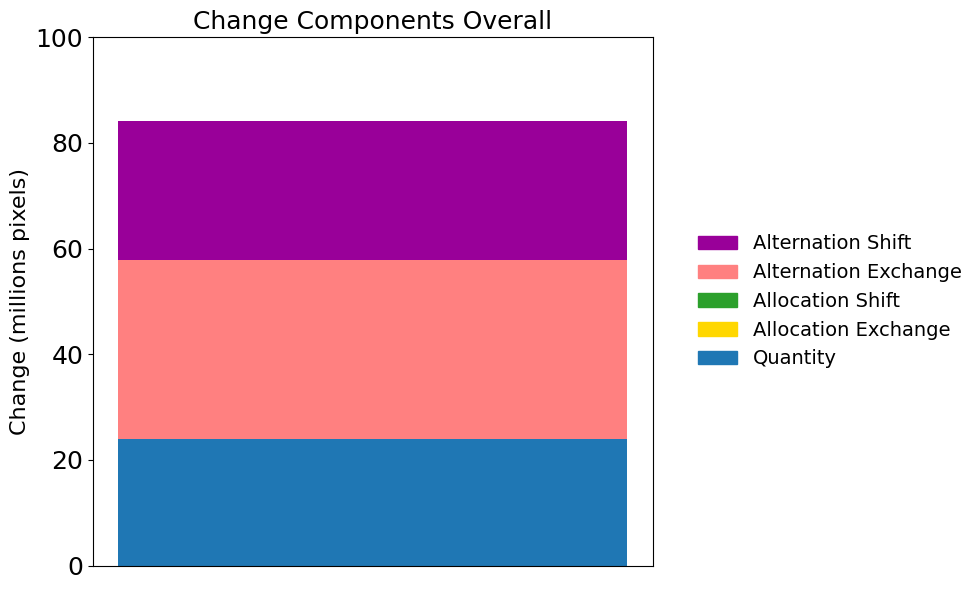

In [ ]:
def plot_components_with_alternation(csv_path, output_path):
    """
    Generates stacked bar chart showing:
    - Quantity (from extent matrix)
    - Exchange + Alternation Exchange
    - Shift + Alternation Shift

    Args:
        csv_path: Path to change_components.csv
        output_path: Directory to save the graphic
    """
    # Load data
    df = pd.read_csv(csv_path)

    # Define colors and component order
    COMPONENT_COLORS = {
        'Quantity': '#1f77b4',
        'Exchange': '#ffd700',
        'Alternation_Exchange': '#ff8080',
        'Shift': '#2ca02c',
        'Alternation_Shift': '#990099'
    }

    COMPONENT_ORDER = [
        'Quantity',
        'Exchange',
        'Shift',
        'Alternation_Exchange',
        'Alternation_Shift'
    ]

    # Calculate component totals
    component_totals = {
        'Quantity': df[(df['Component'] == 'Quantity') &
                      (df['Time_Interval'] == 'extent')]['Gain'].sum(),

        'Allocation_Exchange': df[(df['Component'] == 'Allocation_Exchange') &
                      (df['Time_Interval'] == 'extent')]['Gain'].sum(),

        'Allocation_Shift': df[(df['Component'] == 'Allocation_Shift') &
                   (df['Time_Interval'] == 'extent')]['Gain'].sum(),

        'Alternation_Exchange': df[df['Component'] == 'Alternation_Exchange']['Gain'].sum(),


        'Alternation_Shift': df[df['Component'] == 'Alternation_Shift']['Gain'].sum()
    }

    # Create figure with original styling
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot stacked bars
    bottom = 0
    bars = []
    labels = []

    for component in component_order:
        value = component_totals.get(component, 0)
        bar = ax.bar(
            x=0,
            height=value,
            bottom=bottom,
            color=components_color[component],
            edgecolor='none',
            width=1
        )
        bars.append(bar[0])
        labels.append(component.replace('_', ' '))
        bottom += value

    # Axis formatting
    ax.set_ylabel('Change (millions pixels)',
                  fontsize=16)
    ax.set_title('Change Components Overall',
                 fontsize=18)
    ax.xaxis.set_visible(False)
    ax.tick_params(axis='both', which='major',
                   labelsize=18)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Remove chart borders
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(True)

    # Configuring y-axis to scale with millions
    def millions_formatter(x, pos):
        return '%1.0f' % (x * 1e-6)
    ax.set_ylim(0, 10e7)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20000000))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

    # Legend
    legend_elements = [
        plt.Rectangle((0,0),1,1, color=COMPONENT_COLORS['Alternation_Shift'], label='Alternation Shift'),
        plt.Rectangle((0,0),1,1, color=COMPONENT_COLORS['Alternation_Exchange'], label='Alternation Exchange'),
        plt.Rectangle((0,0),1,1, color=COMPONENT_COLORS['Shift'], label='Allocation Shift'),
        plt.Rectangle((0,0),1,1, color=COMPONENT_COLORS['Exchange'], label='Allocation Exchange'),
        plt.Rectangle((0,0),1,1, color=COMPONENT_COLORS['Quantity'], label='Quantity')
    ]
    ax.legend(handles=legend_elements,
            loc='center left',
            bbox_to_anchor=(1.05, 0.5),
            fontsize=14,
            frameon=False)

    # Save and display
    plt.tight_layout()
    plt.savefig(
        os.path.join(output_path, "graphic_change_components_overall.jpeg"),
        format='jpeg',
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()

if __name__ == "__main__":
    csv_file = os.path.join(output_path, "change_components.csv")

    # Generate visualization
    plot_components_with_alternation(csv_file, output_path)

### **5.4 Change Componentes by Class**

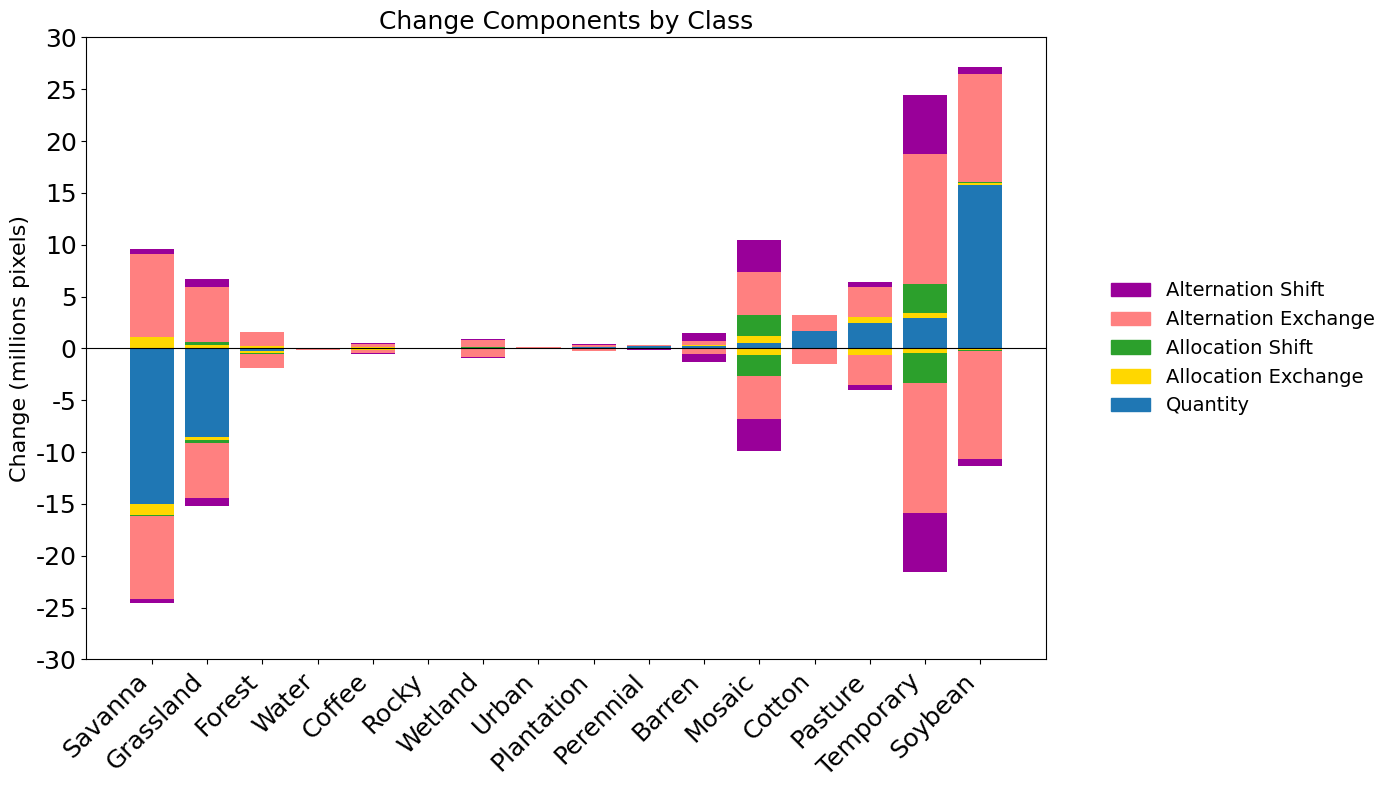

In [ ]:
class ComponentVisualizer:
    """Class to visualize components including alternation"""

    @staticmethod
    def plot_gain_loss_stacked(class_labels_dict, title, output_path):
        """Plot gains and losses with alternation components"""
        # Access predefined parameters from global scope
        global df, components_color, component_order
        global figsize, title_fontsize, label_fontsize, tick_labelsize, legend_fontsize

        # Filter data using original criteria
        filtered_df = df[df['Time_Interval'].isin(['extent', 'alternation'])]

        # Class sorting logic
        existing_classes = [cls for cls in filtered_df['Class'].unique() if cls != 0]
        class_totals = []

        for cls in existing_classes:
            class_data = filtered_df[filtered_df['Class'] == cls]
            quantity_gain = class_data[class_data['Component'] == 'Quantity']['Gain'].sum()
            quantity_loss = class_data[class_data['Component'] == 'Quantity']['Loss'].sum()
            class_totals.append((cls, quantity_gain - quantity_loss))

        sorted_classes = sorted(class_totals, key=lambda x: x[1])
        ordered_classes = [cls for cls, _ in sorted_classes]

        # Create figure using predefined dimensions
        fig, ax = plt.subplots(figsize=(14, 8))
        fig.subplots_adjust(left=0.1, right=0.75)
        x_positions = np.arange(len(ordered_classes))
        width = 0.8

        # Plot each class using predefined component order
        for idx, cls in enumerate(ordered_classes):
            class_data = filtered_df[filtered_df['Class'] == cls]

            gain_bottom = loss_bottom = 0
            for comp in component_order:
                # Plot gains
                gains = class_data[class_data['Component'] == comp]['Gain'].sum()
                ax.bar(x_positions[idx],
                       gains,
                       width,
                       bottom=gain_bottom,
                       color=components_color[comp],
                       edgecolor='none')
                gain_bottom += gains

                # Plot losses
                losses = -class_data[class_data['Component'] == comp]['Loss'].sum()
                ax.bar(x_positions[idx],
                       losses,
                       width,
                       bottom=loss_bottom,
                       color=components_color[comp],
                       edgecolor='none')
                loss_bottom += losses

        # Axis formatting with predefined parameters
        class_names = [class_labels_dict.get(cls, {}).get("rename", f"{cls}") for cls in ordered_classes]
        ax.set_xticks(x_positions)
        ax.set_xticklabels(class_names,
                           rotation=45,
                           ha='right',
                           fontsize=18)
        ax.axhline(0,
                   color='black',
                   linewidth=0.8)
        ax.set_ylabel('Change (millions pixels)',
                      fontsize=16)
        ax.set_title(title,
                     fontsize=18)
        ax.tick_params(axis='both',
                       which='major',
                       labelsize=18)
        ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        # Configuring y-axis to scale with millions
        def millions_formatter(x, pos):
            return '%1.0f' % (x * 1e-6)
        ax.set_ylim(-3e7, 3e7)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(5000000))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

        COMPONENT_COLORS = {
            'Quantity': '#1f77b4',
            'Exchange': '#ffd700',
            'Alternation_Exchange': '#ff8080',
            'Shift': '#2ca02c',
            'Alternation_Shift': '#990099',
            'Allocation_Exchange': '#ffd700',  # Add Allocation_Exchange
            'Allocation_Shift': '#2ca02c'     # Add Allocation_Shift
        }

        # Legend
        legend_elements = [
            plt.Rectangle((0,0),1,1, color=COMPONENT_COLORS['Alternation_Shift'], label='Alternation Shift'),
            plt.Rectangle((0,0),1,1, color=COMPONENT_COLORS['Alternation_Exchange'], label='Alternation Exchange'),
            plt.Rectangle((0,0),1,1, color=COMPONENT_COLORS['Shift'], label='Allocation Shift'),
            plt.Rectangle((0,0),1,1, color=COMPONENT_COLORS['Exchange'], label='Allocation Exchange'),
            plt.Rectangle((0,0),1,1, color=COMPONENT_COLORS['Quantity'], label='Quantity')
        ]

        ax.legend(handles=legend_elements,
                loc='center left',
                bbox_to_anchor=(1.05, 0.5),
                fontsize=14,
                frameon=False)

        # Save and show plot
        plt.tight_layout()
        plt.savefig(
            os.path.join(output_path,
                         "graphic_change_component_change_class.jpeg"),
            format='jpeg',
            dpi=300,
            bbox_inches='tight'
        )
        plt.show()

ComponentVisualizer.plot_gain_loss_stacked(
    class_labels_dict,
    "Change Components by Class",
    output_path
)

## **6. Trajectory Classification**


---
### Overview
This section provides a framework for processing and classifying pixel trajectories in raster datasets using the Numba library to enhance performance. The approach is designed to handle large datasets efficiently by utilizing parallel processing.

### Components

#### 1. **Function: `classify_pixel`**
   - **Purpose:** Classifies each pixel series into one of four possible trajectory types based on its temporal changes.
   - **Method:** Employs Numba's `@njit` decorator for faster execution. The function analyzes the pixel series to detect variations and direct transitions between the start and the end of the series.
   - **Categories:**
     - `0`: Represents no-data at the start of the series.
     - `1`: Stable trajectory without any change.
     - `2`: Stable trajectory with alterations.
     - `3`: Direct transition from the starting to the ending class.
     - `4`: Indirect transition, with no straightforward path from start to end.

#### 2. **Function: `process_stack_parallel`**
   - **Purpose:** Processes a stack of raster images in parallel, classifying each pixel according to its trajectory.
   - **Method:** Optimized with Numba's `@njit` and `parallel` decorators to handle operations concurrently across multiple cores, producing a 2D array of classification results.

#### 3. **Class: `TrajectoryAnalyzer`**
   - **Method:** Facilitates organized raster processing including loading, classifying, and saving operations.
   - **Key Functionality:**
     - `process_rasters`: Manages the processing of raster files by loading them in chunks, classifying each chunk, and writing the results to a new file. It handles large datasets by loading data in manageable chunks and updating the metadata accordingly.


In [ ]:
@nb.njit(nogil=True, cache=True)
def analyze_pixel_series(pixel_series):
    """Numba-optimized trajectory classification using transition matrices"""
    if pixel_series[0] == 0:  # Skip masked pixels
        return 0

    # Find unique classes and create mapping
    classes = np.unique(pixel_series)
    max_class = np.max(classes)
    trans_matrix = np.zeros((max_class+1,
                             max_class+1),
                            dtype=np.int32)

    # Build transition matrix
    prev = pixel_series[0]
    for curr in pixel_series[1:]:
        if curr != prev:
            trans_matrix[prev, curr] += 1
            prev = curr

    # Calculate components
    exchange = 0
    total_trans = np.sum(trans_matrix)

    # Iterate only over existing classes
    for cls in classes:
        for other in classes:
            if cls < other:
                exchange += min(trans_matrix[cls, other],
                                trans_matrix[other, cls])

    shift = total_trans - 2 * exchange
    shift = max(0, shift) if len(classes) >= 3 else 0

    # Classification logic
    quantity = 1 if pixel_series[0] != pixel_series[-1] else 0

    if quantity == 0:
        if exchange > 0 and shift == 0: return 2
        if exchange == 0 and shift > 0: return 3
        if exchange > 0 and shift > 0: return 4
        return 1
    else:
        if exchange == 0 and shift == 0: return 5
        if exchange > 0 and shift == 0: return 6
        if exchange == 0 and shift > 0: return 7
        return 8

@nb.njit(nogil=True, parallel=True)
def process_pixels_parallel(stack, height, width):
    """Parallel pixel processing using all CPU cores"""
    result = np.zeros((height, width), dtype=np.uint8)
    for y in nb.prange(height):
        for x in range(width):
            result[y, x] = analyze_pixel_series(stack[:, y, x])
    return result

def process_trajectories(output_path, suffix='_masked.tif'):
    """Optimized processing workflow with chunked processing"""
    # Validate output directory
    os.makedirs(output_path, exist_ok=True)
    if not os.path.isdir(output_path):
        raise ValueError(f"Path must be a directory: {output_path}")

    # Find input files
    image_paths = sorted([
        os.path.join(output_path, f)
        for f in os.listdir(output_path)
        if f.endswith(suffix)
    ])
    if not image_paths:
        raise ValueError(f"No files found with suffix '{suffix}'")

    # Load metadata
    with rasterio.open(image_paths[0]) as src:
        meta = src.meta
        height, width = src.shape

    # Initialize progress bar
    pbar = tqdm(total=height,
                desc="Processing rows",
                unit="row")

    # Process in chunks for memory efficiency
    chunk_size = 500
    result = np.zeros((height, width),
                      dtype=np.uint8)

    for y_start in range(0, height, chunk_size):
        y_end = min(y_start + chunk_size, height)
        chunk_height = y_end - y_start

        # Load chunk data
        stack_chunk = np.zeros((len(image_paths),
                                chunk_height,
                                width),
                               dtype=np.int16)
        for i, path in enumerate(image_paths):
            with rasterio.open(path) as src:
                stack_chunk[i] = src.read(1, window=((y_start, y_end), (0, width)))

        # Process chunk
        result[y_start:y_end] = process_pixels_parallel(stack_chunk, chunk_height, width)
        pbar.update(chunk_height)

    pbar.close()

    # Save results
    meta.update({
        'driver': 'GTiff',
        'dtype': 'uint8',
        'count': 1,
        'nodata': 0,
        'compress': 'lzw'
    })

    output_file = os.path.join(output_path, 'trajectory1.tif')
    with rasterio.open(output_file, 'w', **meta) as dst:
        dst.write(result, 1)

if __name__ == "__main__":
    process_trajectories(output_path=output_path)
    print(f"Processing complete! Results saved to: {output_path}")

Processing rows: 100%|██████████| 20480/20480 [01:50<00:00, 185.25row/s]


Processing complete! Results saved to: /content/drive/MyDrive/IALE-APP/output22_nasa/


### 6.1 Map visualization

This section processes and visualizes raster data by scaling, applying a color map, and adding graphical elements like legends, scale bars, and north arrows. The output is a high-resolution image of the classified raster data.

### Steps

1. **Initialization:**
   - Set the path for the raster file.
   - Define image resolution (`dpi`) and scaling factor.

2. **Legend Configuration:**
   - Define colors and descriptions for different data categories in the raster.

3. **Raster Processing:**
   - Read and rescale raster data.
   - Adjust the transformation matrix for new dimensions.
   - Extract and use geographic boundaries to set the plot extent.

4. **Visualization Enhancements:**
   - Plot the data using matplotlib.
   - Add a scale bar and a north arrow for orientation.
   - Customize axes and labels for clarity.

5. **Output:**
   - Save the plotted image to a specified directory.
   - Display the plot and close it to free up memory.

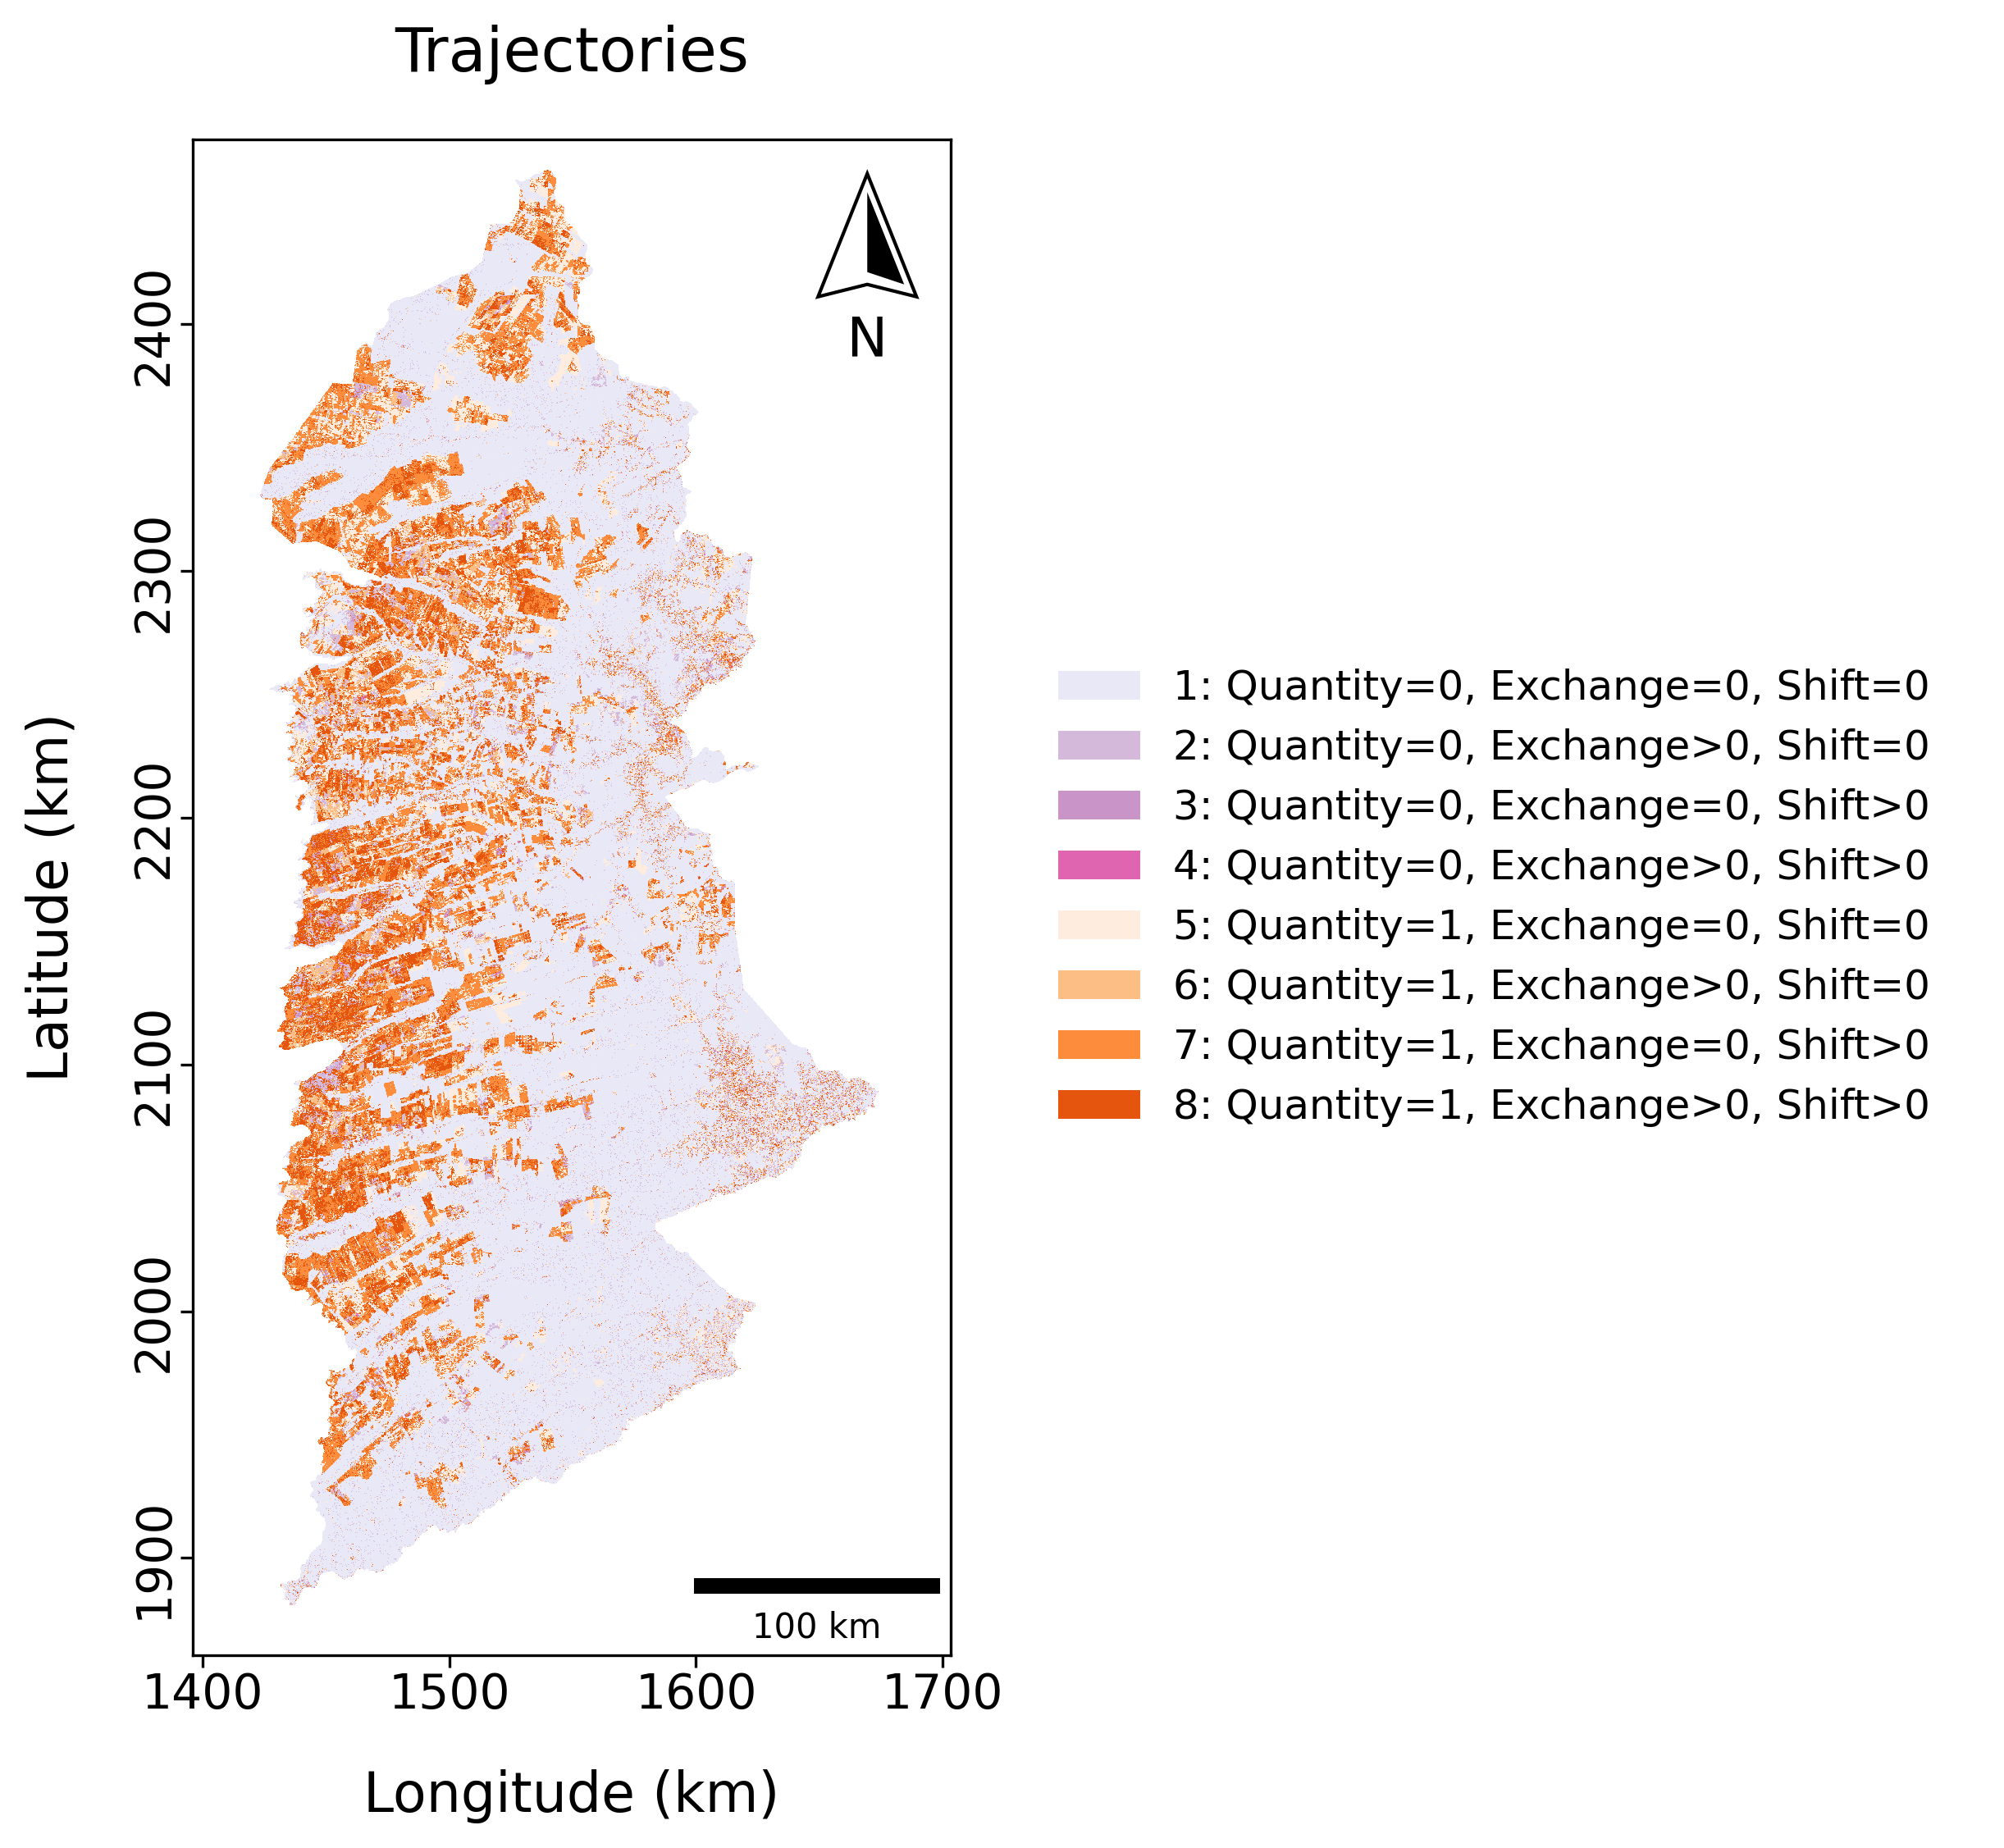

Map saved successfully in the folder: /content/drive/MyDrive/IALE-APP/output22_nasa/


In [ ]:
# Set the path for the input raster file
raster_path = os.path.join(output_path, 'trajectory1.tif')

# Set the resolution quality of the output image
dpi = 300

# Define a scale factor to resize the raster data
scale_factor = 0.15

# Define legend elements with specific colors and labels explaining the trajectory types
legend_elements = [
    Rectangle((0, 0), 1, 1, facecolor='#e8e8f6', label='1: Quantity=0, Exchange=0, Shift=0'),
    Rectangle((0, 0), 1, 1, facecolor='#d4b9da', label='2: Quantity=0, Exchange>0, Shift=0'),
    Rectangle((0, 0), 1, 1, facecolor='#c994c7', label='3: Quantity=0, Exchange=0, Shift>0'),
    Rectangle((0, 0), 1, 1, facecolor='#df65b0', label='4: Quantity=0, Exchange>0, Shift>0'),
    Rectangle((0, 0), 1, 1, facecolor='#feedde', label='5: Quantity=1, Exchange=0, Shift=0'),
    Rectangle((0, 0), 1, 1, facecolor='#fdbe85', label='6: Quantity=1, Exchange>0, Shift=0'),
    Rectangle((0, 0), 1, 1, facecolor='#fd8d3c', label='7: Quantity=1, Exchange=0, Shift>0'),
    Rectangle((0, 0), 1, 1, facecolor='#e6550d', label='8: Quantity=1, Exchange>0, Shift>0')
]

# Create a color map with predefined colors for each class in the raster
cmap = ListedColormap([
    '#ffffff',
    '#e8e8f6',
    '#d4b9da',
    '#c994c7',
    '#df65b0',
    '#feedde',
    '#fdbe85',
    '#fd8d3c',
    '#e6550d'
])

# Open the raster file and read the data, applying scaling based on the scale_factor
with rasterio.open(raster_path) as src:
    data = src.read(
        1,
        out_shape=(int(src.height * scale_factor), int(src.width * scale_factor)),
        resampling=rasterio.enums.Resampling.nearest
    )

    # Adjust the transformation matrix to the new data dimensions
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[1]),
        (src.height / data.shape[0])
    )

    # Store the original transformation matrix
    original_transform = src.transform

    # Extract geographic boundaries from the source data
    left, bottom, right, top = src.bounds

    # Create a plotting figure and axes
    fig, ax = plt.subplots(figsize=(14, 8), dpi=dpi)

    # Display the raster data on the axes using the predefined color map
    img = ax.imshow(
        data,
        cmap=cmap,
        extent=[left, right, bottom, top],
        interpolation='none'
    )

    # Add a scale bar to the plot
    scalebar = ScaleBar(
        1/1000,
        units='km',
        length_fraction=0.4,
        location='lower right',
        scale_loc='bottom',
        color='black',
        box_alpha=0,
        scale_formatter=lambda value, _: f"{int(value)} km"
    )
    ax.add_artist(scalebar)

    # Add a north arrow to the plot
    north_arrow(
        ax,
        location="upper right",
        shadow=False,
        rotation={"degrees":0}
    )

    # Custom function to format axis ticks to show distance in kilometers
    def format_ticks(x, _):
        return f'{x/1000:.0f}'

    ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

    ax.set_xlabel("Longitude (km)",
                  fontsize=16,
                  labelpad=15)
    ax.set_ylabel("Latitude (km)",
                  fontsize=16,
                  labelpad=15)
    ax.set_aspect('equal')

    # Style settings for tick labels
    ax.tick_params(axis='both',
                   which='major',
                   labelsize=14,
                   labelrotation=0,
                   pad=8)

    plt.setp(ax.get_yticklabels(),
             rotation=90,
             va='center',
             ha='center')

    # Position all tick labels centrally relative to their ticks
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_horizontalalignment('center')
        label.set_verticalalignment('center')

    # Add a legend to the plot
    legend = ax.legend(
        handles=legend_elements,
        loc='center left',
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
        fontsize=12,
        borderpad=1.2,
        handletextpad=0.8,
        columnspacing=2,
    )

    plt.title("Trajectories",
              fontsize=18,
              pad=20)

    # Save the plot as a JPEG file
    plt.savefig(
        os.path.join(output_path, 'map_trajectories1.jpeg'),
        dpi=dpi,
        bbox_inches='tight',
        pad_inches=0.5,
        pil_kwargs={'optimize': True,
                    'quality': 95}
    )

plt.show()

plt.close()

print("Map saved successfully in the folder:", output_path)

### Trajectories 2

In [ ]:
@nb.njit(nogil=True, cache=True)
def classify_pixel(pixel_series):
    """Numba-optimized trajectory classification (20-50x faster)"""
    if pixel_series[0] == 0:
        return 0

    start = pixel_series[0]
    end = pixel_series[-1]
    has_variation = False
    direct_transition = False

    # First pass: check all conditions in single loop
    for i in range(len(pixel_series)-1):
        current = pixel_series[i]
        next_val = pixel_series[i+1]

        # Check for any variation
        if not has_variation and current != next_val:
            has_variation = True

        # Check for direct transition
        if not direct_transition and current == start and next_val == end:
            direct_transition = True

    # Category 1: Stable with no changes
    if not has_variation:
        return 1

    # Category 2: Stable with alternation
    if start == end:
        return 2

    # Category 3: Direct transition
    if direct_transition:
        return 3

    # Category 4: Indirect transition
    return 4

@nb.njit(nogil=True, parallel=True)
def process_stack_parallel(stack, height, width):
    """Parallel processing of raster stack"""
    result = np.zeros((height, width), dtype=np.uint8)

    for y in nb.prange(height):
        for x in range(width):
            result[y, x] = classify_pixel(stack[:, y, x])

    return result

class TrajectoryAnalyzer:
    @staticmethod
    def process_rasters(output_path, suffix='_masked.tif'):
        """Optimized raster processing with chunked loading"""
        # Validate directory
        os.makedirs(output_path, exist_ok=True)
        if not os.path.isdir(output_path):
            raise ValueError(f"Path must be a directory: {output_path}")

        # Find input files
        raster_files = sorted([
            os.path.join(output_path, f)
            for f in os.listdir(output_path)
            if f.endswith(suffix)
        ])
        if not raster_files:
            raise ValueError(f"No files found with suffix '{suffix}'")

        # Load metadata
        with rasterio.open(raster_files[0]) as src:
            meta = src.meta
            height, width = src.shape

        # Process in memory-friendly chunks
        chunk_size = 500
        result = np.zeros((height, width),
                          dtype=np.uint8)

        for y_start in range(0, height, chunk_size):
            y_end = min(y_start + chunk_size, height)
            chunk_height = y_end - y_start

            # Load chunk data
            stack = np.zeros((len(raster_files),
                              chunk_height,
                              width),
                             dtype=np.uint8)
            for i, f in enumerate(raster_files):
                with rasterio.open(f) as src:
                    stack[i] = src.read(1, window=((y_start, y_end), (0, width)))

            # Process chunk
            result[y_start:y_end] = process_stack_parallel(stack,
                                                           chunk_height,
                                                           width)

        # Save results
        meta.update({
            'dtype': 'uint8',
            'nodata': 0,
            'count': 1,
            'compress': 'lzw'
        })
        output_file = os.path.join(output_path, 'trajectory2.tif')
        with rasterio.open(output_file, 'w', **meta) as dst:
            dst.write(result, 1)

        return output_file

if __name__ == "__main__":
    TrajectoryAnalyzer.process_rasters(output_path)
    print(f"Processing complete! Results saved to: {output_path}")

Processing complete! Results saved to: /content/drive/MyDrive/IALE-APP/output22_nasa/


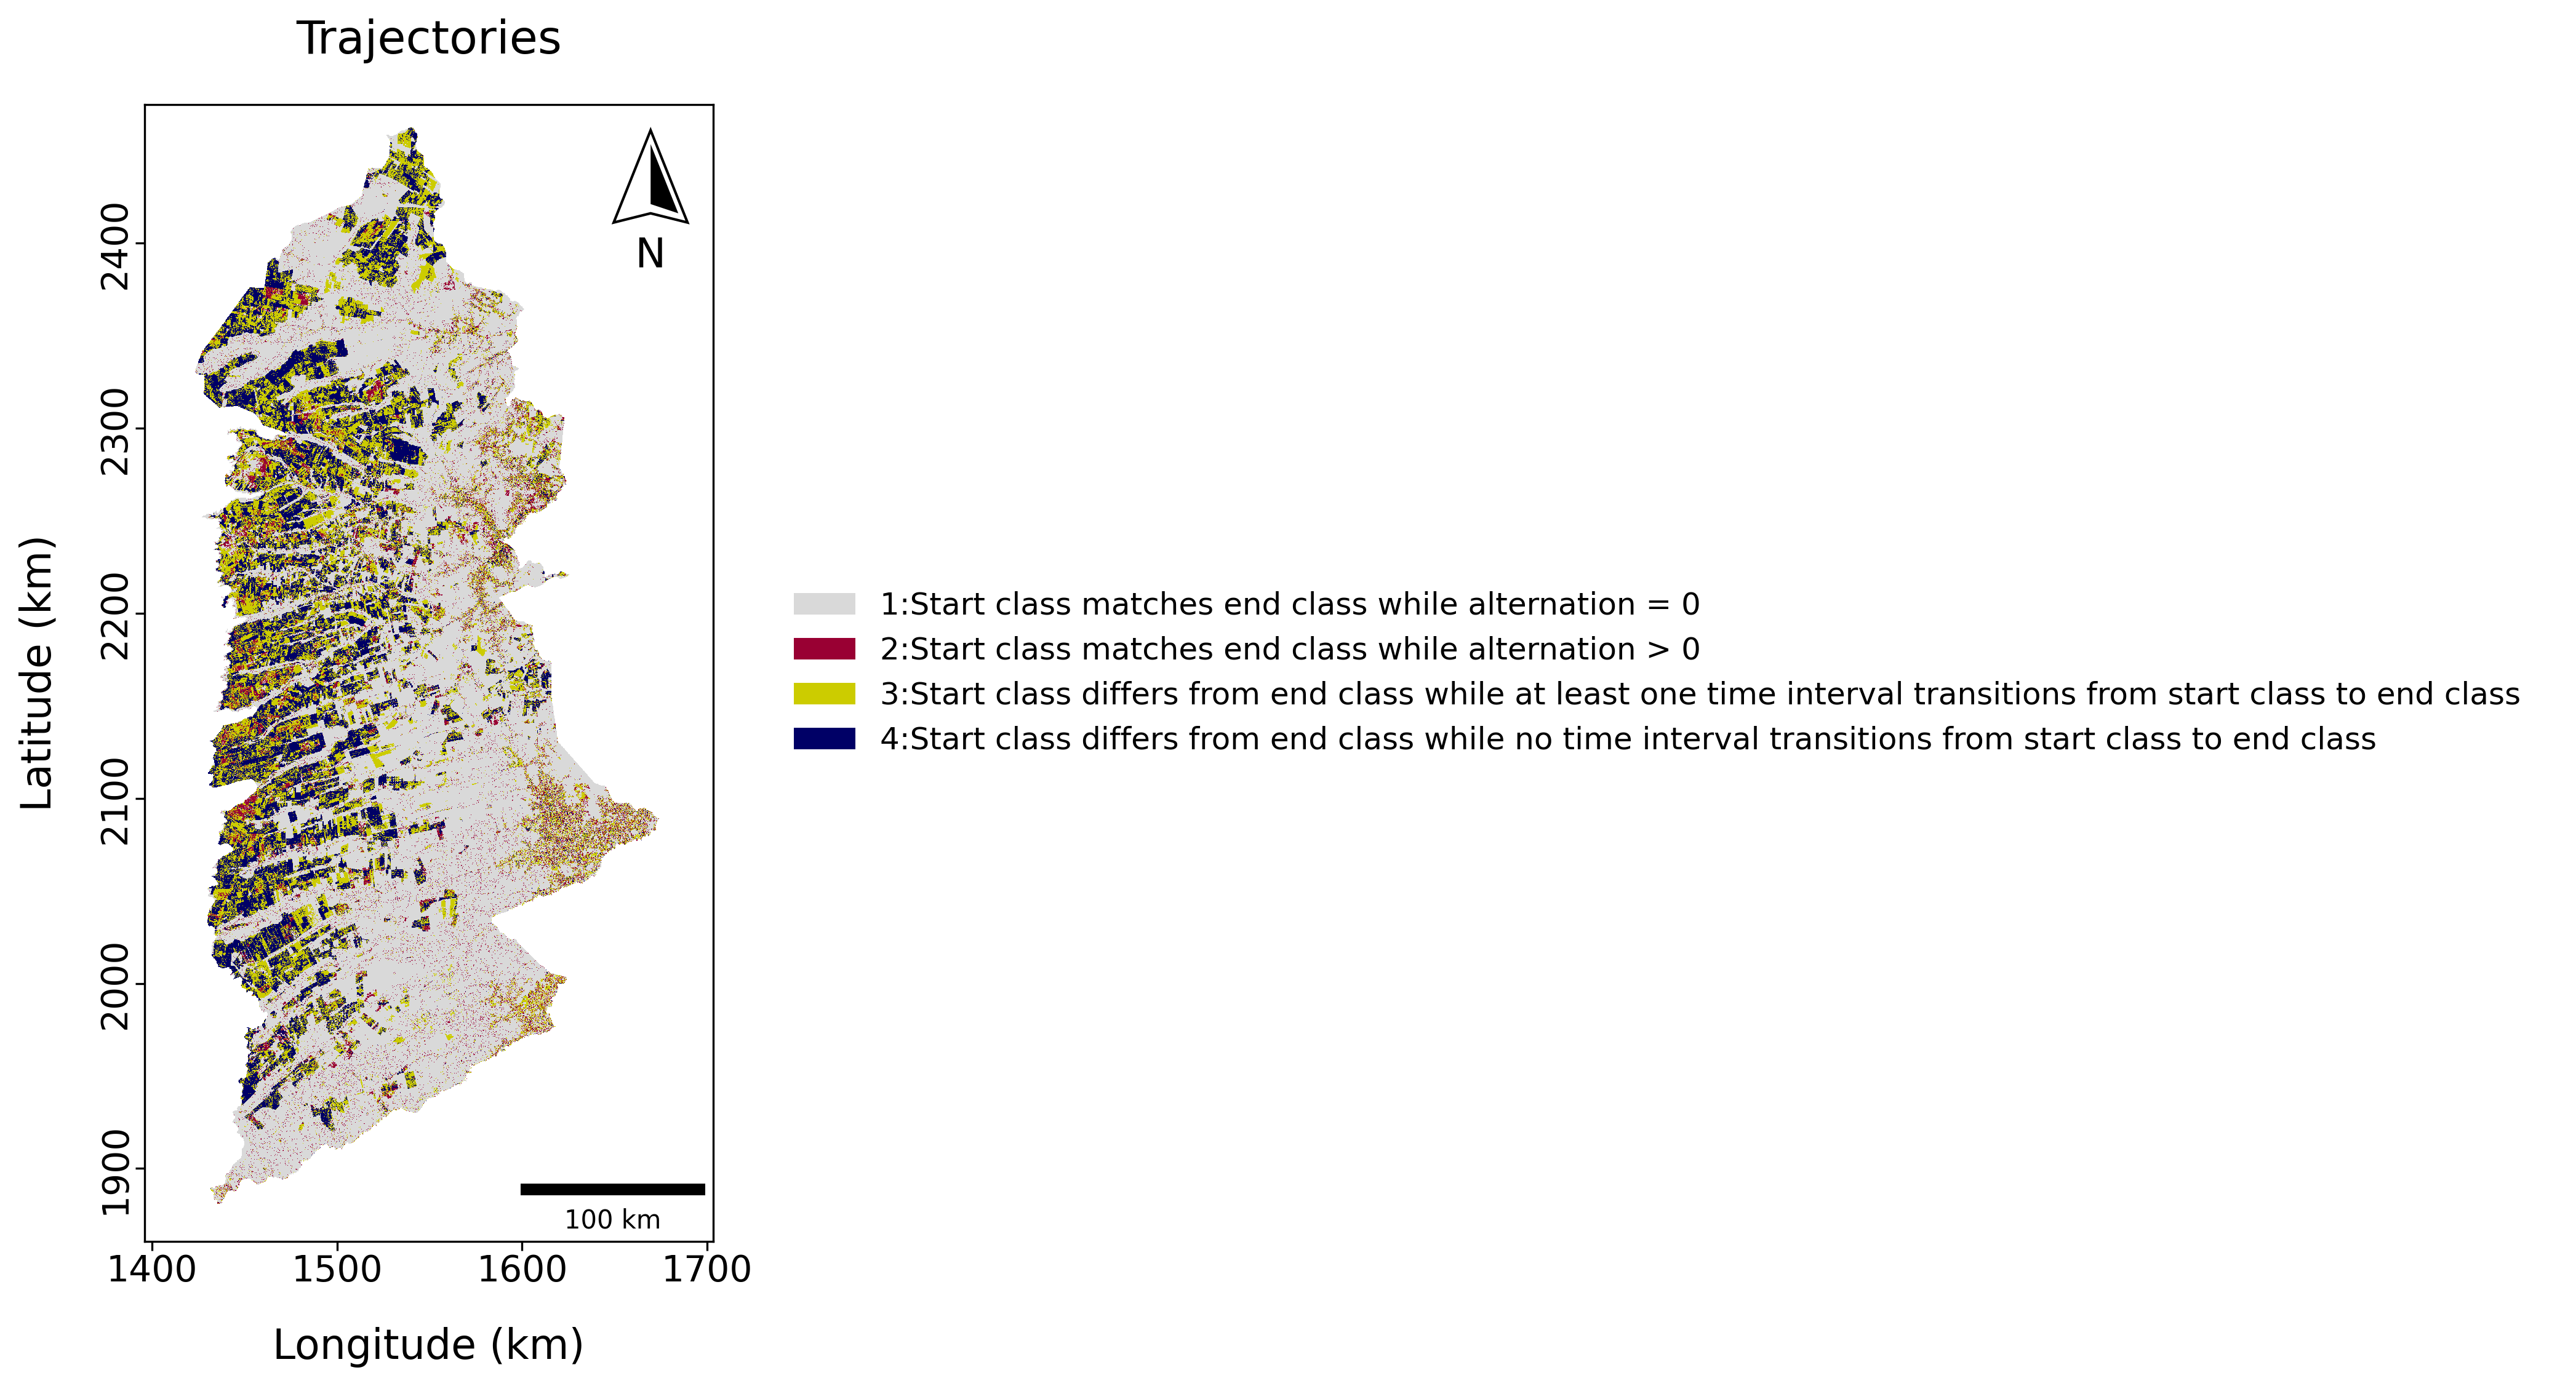

Map saved successfully in the folder: /content/drive/MyDrive/IALE-APP/output22_nasa/


In [ ]:
# Set the path for the input raster file
raster_path = os.path.join(output_path, 'trajectory2.tif')

# Set the resolution quality of the output image
dpi = 300

# Define a scale factor to resize the raster data
scale_factor = 0.15

# Define legend elements with specific colors and labels explaining the trajectory types
legend_elements = [
    Rectangle((0, 0), 1, 1, facecolor='#d9d9d9', label='1:Start class matches end class while alternation = 0'),
    Rectangle((0, 0), 1, 1, facecolor='#990033', label='2:Start class matches end class while alternation > 0'),
    Rectangle((0, 0), 1, 1, facecolor='#cccc00', label='3:Start class differs from end class while at least one time interval transitions from start class to end class'),
    Rectangle((0, 0), 1, 1, facecolor='#000066', label='4:Start class differs from end class while no time interval transitions from start class to end class')
]

# Create a color map with predefined colors for each class in the raster
cmap = ListedColormap([
    '#ffffff',
    '#d9d9d9',
    '#990033',
    '#cccc00',
    '#000066',
])

# Open the raster file and read the data, applying scaling based on the scale_factor
with rasterio.open(raster_path) as src:
    data = src.read(
        1,
        out_shape=(int(src.height * scale_factor), int(src.width * scale_factor)),
        resampling=rasterio.enums.Resampling.nearest
    )

    # Adjust the transformation matrix to the new data dimensions
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[1]),
        (src.height / data.shape[0])
    )

    # Store the original transformation matrix
    original_transform = src.transform

    # Extract geographic boundaries from the source data
    left, bottom, right, top = src.bounds

    # Create a plotting figure and axes
    fig, ax = plt.subplots(figsize=(14, 8), dpi=dpi)

    # Display the raster data on the axes using the predefined color map
    img = ax.imshow(
        data,
        cmap=cmap,
        extent=[left, right, bottom, top],
        interpolation='none'
    )

    # Add a scale bar to the plot
    scalebar = ScaleBar(
        1/1000,
        units='km',
        length_fraction=0.4,
        location='lower right',
        scale_loc='bottom',
        color='black',
        box_alpha=0,
        scale_formatter=lambda value, _: f"{int(value)} km"
    )
    ax.add_artist(scalebar)

    # Add a north arrow to the plot
    north_arrow(
        ax,
        location="upper right",
        shadow=False,
        rotation={"degrees":0}
    )

    # Custom function to format axis ticks to show distance in kilometers
    def format_ticks(x, _):
        return f'{x/1000:.0f}'

    ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

    ax.set_xlabel("Longitude (km)",
                  fontsize=16,
                  labelpad=15)
    ax.set_ylabel("Latitude (km)",
                  fontsize=16,
                  labelpad=15)
    ax.set_aspect('equal')

    # Style settings for tick labels
    ax.tick_params(axis='both',
                   which='major',
                   labelsize=14,
                   labelrotation=0,
                   pad=8)

    plt.setp(ax.get_yticklabels(),
             rotation=90,
             va='center',
             ha='center')

    # Position all tick labels centrally relative to their ticks
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_horizontalalignment('center')
        label.set_verticalalignment('center')

    # Add a legend to the plot
    legend = ax.legend(
        handles=legend_elements,
        loc='center left',
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
        fontsize=12,
        borderpad=1.2,
        handletextpad=0.8,
        columnspacing=2,
    )

    plt.title("Trajectories",
              fontsize=18,
              pad=20)

    # Save the plot as a JPEG file
    plt.savefig(
        os.path.join(output_path, 'map_trajectories2.jpeg'),
        dpi=dpi,
        bbox_inches='tight',
        pad_inches=0.5,
        pil_kwargs={'optimize': True,
                    'quality': 95}
    )

plt.show()

plt.close()

print("Map saved successfully in the folder:", output_path)

In [ ]:
total_end_time = time.time()  # End the timer for the whole notebook
total_execution_time = total_end_time - total_start_time  # Calculate the total execution time in seconds
total_execution_time_minutes = total_execution_time / 60  # Convert seconds to minutes
print(f"Total execution time for the notebook: {total_execution_time_minutes:.2f} minutes")

Total execution time for the notebook: 12.20 minutes
